In [23]:
from nltk.tree import Tree
from nltk.util import breadth_first
import os
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup


In [3]:
data_path = '../../data/MovieSummaries/corenlp_plot_summaries/sample/'

In [7]:
file_list = [item for item in os.listdir(data_path) if 'xml' in item]

In [36]:
file_list[0]

'25625475.xml'

In [27]:
f = open(os.path.join(data_path, file_list[0]), 'r').read()
xml = BeautifulSoup(f)

/anaconda3/envs/python36/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /anaconda3/envs/python36/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [32]:
sentences = xml.document.sentences.findAll('sentence')
for sent in sentences:
    print(sent.parse)
    break

In [35]:
len(sentences)

25

In [224]:
str(sentences[5].parse)

'<parse>(ROOT (S (PP (IN On) (NP (DT the) (CD one) (NN hand))) (, ,) (S (NP (PRP she)) (VP (VBZ sympathizes) (PP (IN with) (NP (NP (NNP Patti)) (, ,) (NP (NP (DT a) (ADJP (RB mentally) (JJ unstable)) (JJ alcoholic)) (SBAR (WHNP (WP who)) (S (VP (VBZ depends) (PP (IN on) (NP (NNS witnesses))))))))))) (, ,) (CC and) (S (NP (PRP she)) (VP (VBZ wants) (S (NP (DT the) (NNS rapists)) (VP (TO to) (VP (VB be) (VP (VBN punished))))))) (. .))) </parse>'

In [348]:
s = str(sentences[5].parse).replace('<parse>', '').replace('</parse>', '')
t = Tree.fromstring(s)

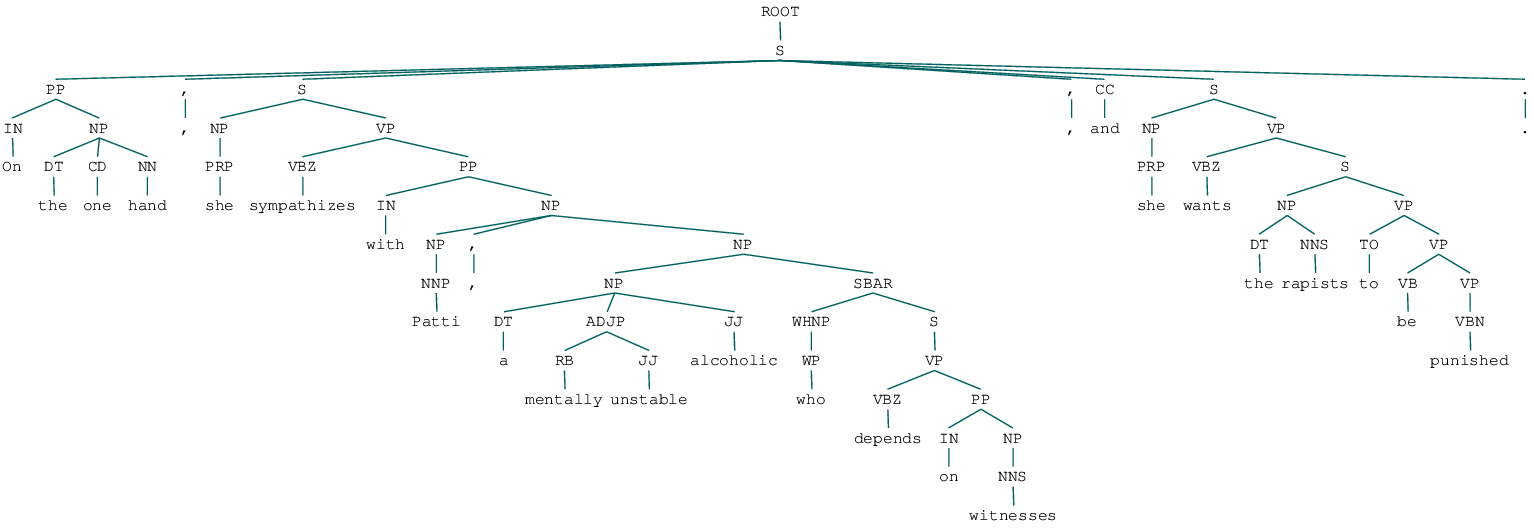

In [349]:
t

In [350]:
t.height()

14

In [351]:
def find_np(sent):
    for c in breadth_first(sent, maxdepth = 2):
        # check if is a leave
        if not isinstance(c, str):
            if c.label() == 'NP':
                return c.leaves()

In [352]:
# VB - Verb, base form
# VBD - Verb, past tense
# VBG - Verb, gerund or present participle
# VBN - Verb, past participle
# VBP - Verb, non-3rd person singular present
# VBZ - Verb, 3rd person singular present

In [353]:
def find_vp(sent):
    vp = []
    for c in breadth_first(sent, maxdepth = 2):
        if not isinstance(c, str):
            if c.label() == 'VP':
                for cc in breadth_first(c, maxdepth = 2):
                    if not isinstance(cc, str):
                        # if a verb is in base form or past tense,
                        # return itself
                        if cc.label() in ['VB', 'VBD']:
                            vp = cc.leaves()
                        # if it's in present form, find the be -ing form
                        elif cc.label() in ['VBG', 'VBN', 'VBP', 'VBZ']:
                            vp.extend(cc.leaves())
    return set(vp)

In [416]:
def process_sentence(tree):
    np_vp = {}
    subtrees = []
    tree = list(tree.subtrees())[1]
    for c in breadth_first(tree, maxdepth = 2):
        subtrees.append(c)
    for st in subtrees[0:len(tree)]:
        print(st)
#         handle nested trees
        if st.label() == 'S':
            process_sentence(st)
        else:
            if not isinstance(st, str):
                if st.label() == 'NP':
                    k = ' '.join([item for item in st.leaves()])
                if st.label() == 'VP':
                    vp = []
                    for cc in breadth_first(st, maxdepth = 2):
                        if not isinstance(cc, str):
                            # if a verb is in base form or past tense,
                            # return itself
                            if cc.label() in ['VB', 'VBD']:
                                vp = cc.leaves()
                            # if it's in present form, find the be -ing form
                            elif cc.label() in ['VBG', 'VBN', 'VBP', 'VBZ']:
                                vp.extend(cc.leaves())
                    v = ' '.join([item for item in vp])
                    np_vp[k] = v
    return np_vp

In [417]:
process_sentence(t)

(S
  (PP (IN On) (NP (DT the) (CD one) (NN hand)))
  (, ,)
  (S
    (NP (PRP she))
    (VP
      (VBZ sympathizes)
      (PP
        (IN with)
        (NP
          (NP (NNP Patti))
          (, ,)
          (NP
            (NP
              (DT a)
              (ADJP (RB mentally) (JJ unstable))
              (JJ alcoholic))
            (SBAR
              (WHNP (WP who))
              (S
                (VP (VBZ depends) (PP (IN on) (NP (NNS witnesses)))))))))))
  (, ,)
  (CC and)
  (S
    (NP (PRP she))
    (VP
      (VBZ wants)
      (S
        (NP (DT the) (NNS rapists))
        (VP (TO to) (VP (VB be) (VP (VBN punished)))))))
  (. .))
(PP (IN On) (NP (DT the) (CD one) (NN hand)))
(IN On)
(PP (IN On) (NP (DT the) (CD one) (NN hand)))
(, ,)
(S
  (NP (PRP she))
  (VP
    (VBZ sympathizes)
    (PP
      (IN with)
      (NP
        (NP (NNP Patti))
        (, ,)
        (NP
          (NP
            (DT a)
            (ADJP (RB mentally) (JJ unstable))
            (JJ alcoholic))
    

{}

In [347]:
if st.label() == 'S':
            k = ' '.join([item for item in find_np(cc)])
            v = ' '.join([item for item in find_vp(cc)])
            np_vp[k] = v

NameError: name 'st' is not defined